# Representation Analysis

In [1]:
import sys

#@markdown Execute this cell to import third-party software into the Colab environment.

# check whether it runs in Colab
root = "."
if "google.colab" in sys.modules:
    print("Running in Colab.")
    !pip3 install timm==0.5.4
    !pip3 install matplotlib==3.7.1
    !pip3 install scikit-learn==1.2.2
    !pip3 install fastai==2.7.12
    !pip3 install einops==0.6.0
    !pip3 install gdown==4.7.1
    !pip3 install yacs==0.1.8    
    !git clone https://github.com/naver-ai/cl-vs-mim.git
    root = "./cl-vs-mim"
    %cd $root

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 7.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 4.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [2]:
import torch

#@markdown Execute this cell to check the Colab environment, including GPU availability.

# check gpu env
print(f"Torch: {torch.__version__} \n" + 
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")

Torch: 2.0.1+cu118 
Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x7f3ee10cc610> 
Device name: Tesla T4


In [3]:
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from fastai.data.external import untar_data, URLs
from utils import subsample

#@markdown Execute this cell to download and import the *Imagenette* dataset, which is a small subset of ImageNet, for simplicity.

# use imagenette (a small subset of imagenet) as an example for simplicity
imagenet_path = untar_data(URLs.IMAGENETTE_160)

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=224, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test, 
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test, 
    num_workers=1, 
    batch_size=16,
)

## Load the Models

In [4]:
# MoCo
import torch
import models.moco as moco
from models.moco import load_state_dict
from utils import download

#@markdown Execute this cell to download and import MoCo-v3 pre-trained model.

name = "moco_vit_b"  #@param {type:"string"}
path = "checkpoints/moco_vit_b.pt"  #@param {type:"string"}
url = "https://dl.fbaipublicfiles.com/moco-v3/vit-b-300ep/vit-b-300ep.pth.tar"  #@param {type:"string"}

download(url, path, force=False)  # download checkpoints

model = moco.vit_base()
model = model.cuda()
model = model.eval()

state_dict = load_state_dict(path)
_ = model.load_state_dict(state_dict, strict=False)
model_moco = model

100%|██████████| 863M/863M [00:39<00:00, 21.6MiB/s]
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
# SimMIM 
import gdown
import torch
import models.simmim as simmim
from models.simmim import load_state_dict

#@markdown Execute this cell to download and import SimMIM pre-trained model.

name = "simmim_vit_b"  #@param {type:"string"}
path = "checkpoints/simmim_vit_b.pt"  #@param {type:"string"}
url = "https://drive.google.com/u/1/uc?id=1dJn6GYkwMIcoP3zqOEyW1_iQfpBi8UOw"  #@param {type:"string"}

gdown.cached_download(url, path, quiet=False)  # download checkpoints

model = simmim.vit_base()
model = model.cuda()
model = model.eval()

state_dict = load_state_dict(path)
_ = model.load_state_dict(state_dict, strict=False)
model_simmim = model

Cached Downloading: checkpoints/simmim_vit_b.pt
Downloading...
From (uriginal): https://drive.google.com/u/1/uc?id=1dJn6GYkwMIcoP3zqOEyW1_iQfpBi8UOw
From (redirected): https://drive.google.com/uc?id=1dJn6GYkwMIcoP3zqOEyW1_iQfpBi8UOw&confirm=t&uuid=0ef71419-53e3-4cd1-bb19-3add1f7fa602
To: /root/.cache/gdown/tmpjs4e96h9/dl
100%|██████████| 345M/345M [00:06<00:00, 57.6MB/s]


=> merge config from configs/simmim_pretrain__vit_base__img224__800ep.yaml


## Fourier Analysis

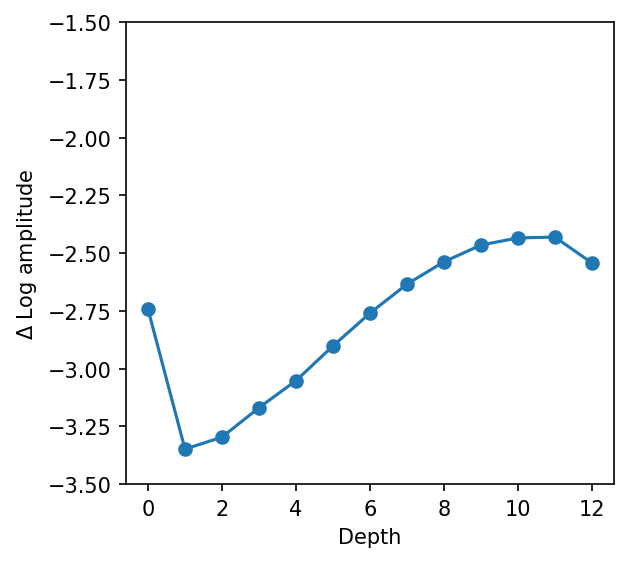

In [6]:
# build off the implementation of https://github.com/xxxnell/how-do-vits-work
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter

def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):  
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
        
        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]  # only use the half-diagonal components
        latent = latent - latent[0]  # visualize 'relative' log amplitudes 
                                     # (i.e., low-freq amp - high freq amp)
        fourier_latents.append(latent)

    return fourier_latents
    
#@markdown Execute this cell to conduct Fourier analysis. The y-axis shows the amplitude (magnitude) of the high-frequency information. 
#@markdown 
#@markdown The results show that CL (MoCo) mainly exploits low-frequency information whereas MIM (SimMIM) exploits high-frequency information.

model_option = "moco"  #@param ["moco", "simmim"]
if model_option == "moco":
    model = model_moco
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)

fourier_latents = AverageMeter()
for i, (xs, ys) in enumerate(dataset_test):
    with torch.no_grad():
        xs = xs.cuda()
        _, zs, _, _ = model(xs)
        zs = zs[:-1]

    latents = [z[:,1:,:] for z in zs]
    _fourier_latents = torch.stack(get_fourier_latents(latents))
    fourier_latents.update(_fourier_latents)

    if i > -1:
        break
        
fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
fourier_latents = fourier_latents.avg
ax.plot(range(13), fourier_latents[:,-1][::2], marker="o")
ax.set_xlabel("Depth")
ax.set_ylabel("$\Delta$ Log amplitude")
ax.set_ylim(top=-1.5, bottom=-3.5)
plt.show()

## Toekn-level t-SNE Visualization

<ipython-input-7-3fbe3e35da21>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def visualize_token_tsne(ax, zs, depth, ys, cmap=cm.get_cmap("plasma")):


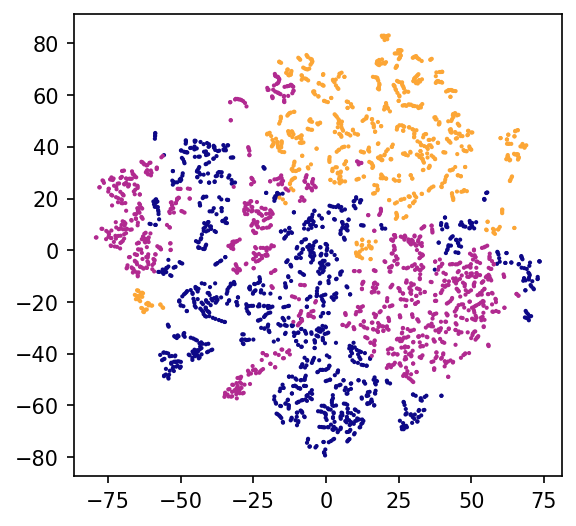

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.manifold import TSNE
from einops import rearrange, reduce, repeat

def visualize_token_tsne(ax, zs, depth, ys, cmap=cm.get_cmap("plasma")): 
    latents = zs[depth]
    latents = latents[:,1:,:]  # drop cls
    latents = rearrange(latents, "b n c -> (b n) c",)
    latents = latents.cpu()

    reducer = TSNE(n_components=2, perplexity=20, learning_rate='auto', init='random', n_iter=1000)
    embedded = reducer.fit_transform(latents)
    
    labels = ys 
    labels = np.array([[label] * 196 for label in labels]).flatten()
    c = [cmap(label / (max(labels) + 0.5)) for label in labels]
    
    ax.scatter(embedded[:,0], embedded[:,1], c=c, s=1)
    
#@markdown Execute this cell to visualize token-level representations by using t-SNE. Note that we visualize 3,528 tokens (196 tokens×18 images) from the representations. 
#@markdown 
#@markdown The tokens of MoCo form a cluster for each image, while those of SimMIM are intermingled. This aligns with the finding that, compared to SimMIM, MoCo is linearly separable. The colors represent three different classes.

model_option = "moco"  #@param ["moco", "simmim"]
depth = 10  #@param {type:"slider", min:0, max:11, step:1}
if model_option == "moco":
    model = model_moco
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)

xs, ys = next(iter(dataset_test))
with torch.no_grad():
    xs = xs.cuda()
    _, zs, _, _ = model(xs)
    zs = zs[:-1]

fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
visualize_token_tsne(ax, zs, depth=depth, ys=ys)  # coloring at the image level